---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [1]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [2]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [3]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [4]:
# Task 2a: Load the data

# YOUR CODE HERE
import pandas as pd
from pathlib import Path

# Assuming your data is in the default "../data" directory
data_directory = "homework-3_data"

# 1. Load the products dataset
df_products = load_wands_products(data_directory)

# 2. Load the queries dataset
df_queries = load_wands_queries(data_directory)

# 3. Load the relevance labels dataset
df_labels = load_wands_labels(data_directory)

# Print the number of rows for each
print(f"Products loaded: {len(df_products):,} rows")
print(f"Queries loaded:  {len(df_queries):,} rows")
print(f"Labels loaded:   {len(df_labels):,} rows")

Products loaded: 42,994 rows
Queries loaded:  480 rows
Labels loaded:   233,448 rows


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [5]:
# YOUR CODE HERE
print(df_products.columns)
print(df_products.head())

##Product name, class, hierarchy, description, and features are useful for search

Index(['product_id', 'product_name', 'product_class', 'category_hierarchy',
       'product_description', 'product_features', 'rating_count',
       'average_rating', 'review_count'],
      dtype='str')
   product_id                                       product_name  \
0           0                            solid wood platform bed   
1           1                        all-clad 7 qt . slow cooker   
2           2            all-clad electrics 6.5 qt . slow cooker   
3           3       all-clad all professional tools pizza cutter   
4           4  baldwin prestige alcott passage knob with roun...   

                  product_class  \
0                          Beds   
1                  Slow Cookers   
2                  Slow Cookers   
3  Slicers, Peelers And Graters   
4                    Door Knobs   

                                  category_hierarchy  \
0  Furniture / Bedroom Furniture / Beds & Headboa...   
1  Kitchen & Tabletop / Small Kitchen Appliances ...   
2  Kitche

In [6]:
# YOUR CODE HERE
print(df_queries.columns)
print(df_queries.head())

## query is useful for search


Index(['query_id', 'query', 'query_class'], dtype='str')
   query_id                      query               query_class
0         0                salon chair            Massage Chairs
1         1         smart coffee table  Coffee & Cocktail Tables
2         2                   dinosaur           Kids Wall Décor
3         3          turquoise pillows            Accent Pillows
4         4  chair and a half recliner                 Recliners


In [7]:
# YOUR CODE HERE
print(df_labels.columns)
print(df_labels.head())


Index(['id', 'query_id', 'product_id', 'label', 'grade'], dtype='str')
   id  query_id  product_id       label  grade
0   0         0       25434       Exact      2
1   1         0       12088  Irrelevant      0
2   2         0       42931       Exact      2
3   3         0        2636       Exact      2
4   4         0       42923       Exact      2


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [8]:
# Task 2c: Understand judgments

# YOUR CODE HERE

print("\nValue Counts for Labels:")
print(df_labels['label'].value_counts())



Value Counts for Labels:
label
Partial       146633
Irrelevant     61201
Exact          25614
Name: count, dtype: int64


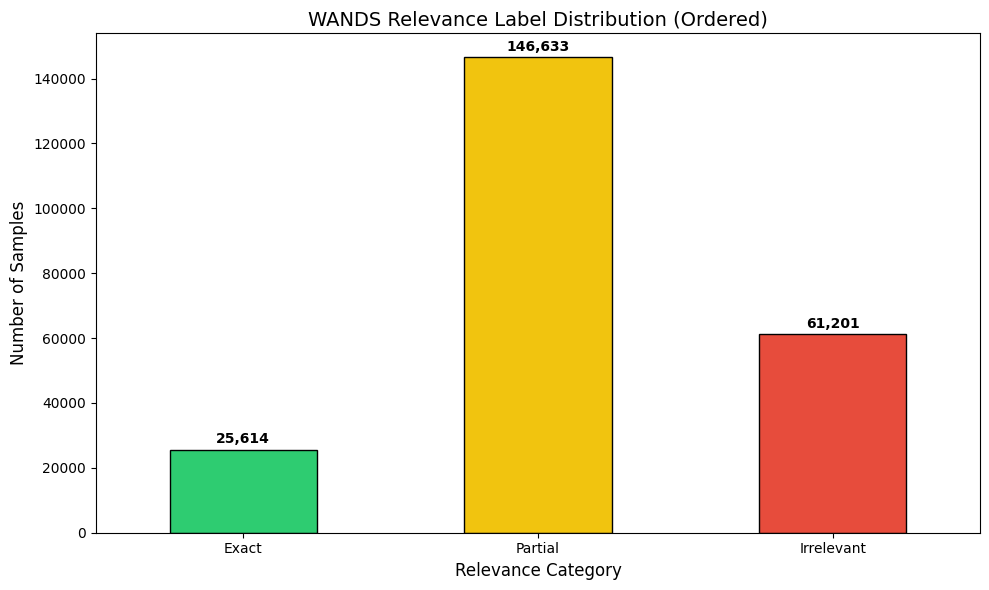

In [9]:
# YOUR CODE HERE

import matplotlib.pyplot as plt

# 1. Define your preferred order
desired_order = ['Exact', 'Partial', 'Irrelevant']

# 2. Get counts and force the specific order
# .reindex() ensures the bars appear exactly as you requested
label_counts = df_labels['label'].value_counts().reindex(desired_order)

# 3. Define colors matching the order
colors = ['#2ecc71', '#f1c40f', '#e74c3c'] # Green, Yellow, Red

# 4. Create the plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=colors, edgecolor='black')

# 5. Add titles and labels
plt.title('WANDS Relevance Label Distribution (Ordered)', fontsize=14)
plt.xlabel('Relevance Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)

# 6. Add count labels on top of the bars
for i, count in enumerate(label_counts):
    plt.text(i, count + 1000, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

#Code provided with help of google gemini

---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [10]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [11]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [12]:
# Task 3a: Create BM25 index for product_name

# YOUR CODE HERE


In [13]:
# Convert to list to ensure it works smoothly with build_index
product_names = df_products['product_name'].tolist()

# Build the inverted index and tokenize
product_name_index, product_name_doc_lengths = build_index(product_names, snowball_tokenize)

print(f"Index built with {len(product_name_index):,} unique stemmed terms.")
print(type(product_name_index))

Index built with 25,570 unique stemmed terms.
<class 'dict'>


In [14]:
# Check index
first_few_terms = list(product_name_index.items())[:5]

print(f"{'Term':<15} | {'Doc ID: Count Mapping'}")
print("-" * 50)

for term, locations in first_few_terms:
    # We only show the first 3 document IDs for each term to keep it clean
    sample_locations = dict(list(locations.items())[:3])
    print(f"{term:<15} | {sample_locations}...")

Term            | Doc ID: Count Mapping
--------------------------------------------------
solid           | {0: 1, 31: 1, 32: 1}...
wood            | {0: 1, 16: 1, 33: 1}...
platform        | {0: 1, 305: 1, 737: 1}...
bed             | {0: 1, 13: 1, 53: 1}...
all             | {1: 1, 2: 1, 3: 2}...


In [15]:
# Sample search
sample_query = "sofa" 
results = search_products(
    query=sample_query,
    products_df=df_products,
    index=product_name_index,
    doc_lengths=product_name_doc_lengths,
    tokenizer=snowball_tokenize,
    k=5
)

print(f"\nTop results for: '{sample_query}'")
display(results[['rank', 'score', 'product_name', 'product_class']])
#print(f"{results}")



Top results for: 'sofa'


,rank,score,product_name,product_class
20392,1,5.361661,kids sofa,Kids Chairs
21389,2,5.361661,child sofa,Kids Chairs
17784,3,5.195259,sofa bed adjustable folding futon sofa video g...,Futons
31606,4,4.930615,home theater sofa,Home Theater Seating
29789,5,4.930615,berlinville patio sofa,NaN


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [16]:
# Task 3b: Add product_description to search

# YOUR CODE HERE


In [17]:
# Product description index and search 

# Convert to list to ensure it works smoothly with build_index
product_description = df_products['product_description'].tolist()

# Build the inverted index and tokenize
product_description_index, product_description_doc_lengths = build_index(product_description, snowball_tokenize)

print(f"Index built with {len(product_description_index):,} unique stemmed terms.")
print(type(product_description_index))

# Check index
first_few_terms = list(product_description_index.items())[:5]

print(f"{'Term':<15} | {'Doc ID: Count Mapping'}")
print("-" * 50)

for term, locations in first_few_terms:
    # We only show the first 3 document IDs for each term to keep it clean
    sample_locations = dict(list(locations.items())[:3])
    print(f"{term:<15} | {sample_locations}...")


# Sample search
sample_query = "sofa" 
results = search_products(
    query=sample_query,
    products_df=df_products,
    index=product_description_index,
    doc_lengths=product_description_doc_lengths,
    tokenizer=snowball_tokenize,
    k=5
)

print(f"\nTop results for: '{sample_query}'")
display(results[['rank', 'score', 'product_name', 'product_class']])

Index built with 20,386 unique stemmed terms.
<class 'dict'>
Term            | Doc ID: Count Mapping
--------------------------------------------------
good            | {0: 1, 23: 1, 71: 1}...
deep            | {0: 1, 14: 1, 273: 1}...
sleep           | {0: 1, 12: 1, 35: 1}...
can             | {0: 2, 1: 2, 4: 1}...
be              | {0: 3, 5: 1, 6: 1}...

Top results for: 'sofa'


,rank,score,product_name,product_class
33424,1,5.745982,malta teak patio sofa with cushions,Patio Sofas
9023,2,5.713906,3d bubble lattice box cushion armchair slipcover,Slipcovers
654,3,5.569171,modern l-shaped reversible sectional sofa couc...,Sectionals
42060,4,5.513641,stines 131 '' wide reversible modular sofa & c...,Sectionals
19817,5,5.475738,mcgray 83.07 '' wide left hand facing modular ...,Sectionals


In [18]:
# 1. Calculate scores for each field independently
# These return NumPy arrays of length len(df_products)
name_scores = score_bm25(
    query=sample_query, 
    index=product_name_index, 
    num_docs=len(df_products), 
    doc_lengths=product_name_doc_lengths, 
    tokenizer=snowball_tokenize
)

desc_scores = score_bm25(
    query=sample_query, 
    index=product_description_index, 
    num_docs=len(df_products), 
    doc_lengths=product_description_doc_lengths, 
    tokenizer=snowball_tokenize
)

# 2. Combine the scores (Simple Addition)
combined_scores = name_scores + desc_scores

# 3. Get the top K results based on the combined score
k = 5
top_k_idx = np.argsort(-combined_scores)[:k]

# 4. Create the results DataFrame
combined_results = df_products.iloc[top_k_idx].copy()
combined_results['score'] = combined_scores[top_k_idx]
combined_results['rank'] = range(1, k + 1)

print(f"\nTop results for: '{sample_query}' (Combined Name + Description)")
display(combined_results[['rank', 'score', 'product_name', 'product_class']])


Top results for: 'sofa' (Combined Name + Description)


,rank,score,product_name,product_class
41464,1,10.383845,holguin convertible sofa,Futons
8308,2,10.227165,twin convertible sofa,Futons
20392,3,9.997183,kids sofa,Kids Chairs
20618,4,9.995396,aines kids sofa,Kids Chairs
38543,5,9.787988,sofa bed with ottoman,NaN


In [19]:
# DOUBLE CHECK WORK


sample_query = "sofa" 


#Product Name search
product_names = df_products['product_name'].tolist()
product_name_index, product_name_doc_lengths = build_index(product_names, snowball_tokenize)
name_results = search_products(
    query=sample_query,
    products_df=df_products,
    index=product_name_index,
    doc_lengths=product_name_doc_lengths,
    tokenizer=snowball_tokenize,
    k=5
)

print(f"\nTop results for: '{sample_query}' based on product name")
display(name_results[['rank', 'score', 'product_name', 'product_class']])


#Product description search
product_description = df_products['product_description'].tolist()
product_description_index, product_description_doc_lengths = build_index(product_description, snowball_tokenize)
description_results = search_products(
    query=sample_query,
    products_df=df_products,
    index=product_description_index,
    doc_lengths=product_description_doc_lengths,
    tokenizer=snowball_tokenize,
    k=5
)

print(f"\nTop results for: '{sample_query}' based on description")
display(description_results[['rank', 'score', 'product_name', 'product_class']])




Top results for: 'sofa' based on product name


,rank,score,product_name,product_class
20392,1,5.361661,kids sofa,Kids Chairs
21389,2,5.361661,child sofa,Kids Chairs
17784,3,5.195259,sofa bed adjustable folding futon sofa video g...,Futons
31606,4,4.930615,home theater sofa,Home Theater Seating
29789,5,4.930615,berlinville patio sofa,NaN



Top results for: 'sofa' based on description


,rank,score,product_name,product_class
33424,1,5.745982,malta teak patio sofa with cushions,Patio Sofas
9023,2,5.713906,3d bubble lattice box cushion armchair slipcover,Slipcovers
654,3,5.569171,modern l-shaped reversible sectional sofa couc...,Sectionals
42060,4,5.513641,stines 131 '' wide reversible modular sofa & c...,Sectionals
19817,5,5.475738,mcgray 83.07 '' wide left hand facing modular ...,Sectionals


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [20]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#
# YOUR ANSWER HERE
# Log2 makes it so that the discount increases as the position gets lower on the list (inverse relationship). 
# This is good, because results in lower positions are less likely to be seen and matter, so they should be more discounted.
# Log2 makes it so position 10 is more devalued more than position 1, so results at position 10 are counted less.

### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

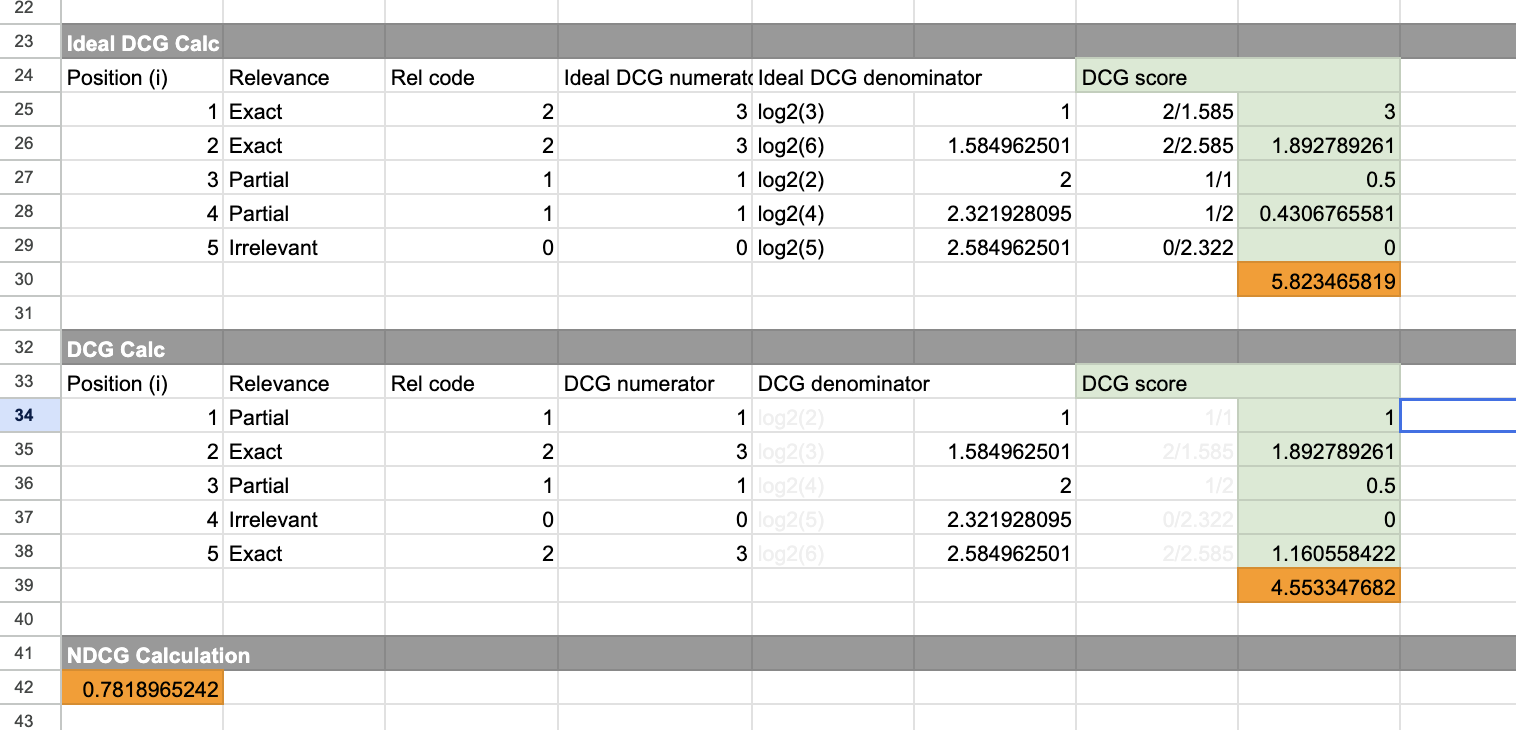

In [21]:
# Task 4b: Calculate NDCG by hand

# YOUR CODE HERE

from IPython.display import Image
Image(filename='/Users/kmorris22/ce-personal/Homework/homework-3_data/DCG hand calc.png')

### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [22]:
# Task 4c: Implement NDCG function

# YOUR CODE HERE


In [23]:
import numpy as np

def calculate_dcg(relevances, k=5):
 
    relevances = np.array(relevances[:k])
    
    #(2^rel - 1)
    numerator = 2**relevances - 1
    
    #log2(i + 1)
    positions = np.arange(1, len(relevances) + 1)
    denominator = np.log2(positions + 1)
    
    scores = numerator / denominator
    return np.sum(scores)

def calculate_ndcg(relevances, k=5):

    # Actual DCG
    actual_dcg = calculate_dcg(relevances, k)
    
    # Ideal DCG: Sort relevances descending to get the best possible order
    ideal_relevances = sorted(relevances, reverse=True)
    idcg = calculate_dcg(ideal_relevances, k)
    
    # Avoid division by zero if all results are irrelevant
    if idcg == 0:
        return 0.0
        
    return actual_dcg / idcg


In [24]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [25]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [26]:
# Task 5a: Run evaluation on all queries

# YOUR CODE HERE


In [27]:
# Create a search function
def combined_search(query: str) -> pd.DataFrame:
 
    # Consider scores for name
    name_scores = score_bm25(
        query, product_name_index, len(df_products), 
        product_name_doc_lengths, snowball_tokenize
    )
    
    # Consider scores for description
    desc_scores = score_bm25(
        query, product_description_index, len(df_products), 
        product_description_doc_lengths, snowball_tokenize
    )

    combined_scores = name_scores + desc_scores
    
    # 4. Attach to products and sort
    results = df_products.copy()
    results['score'] = combined_scores
    return results.sort_values('score', ascending=False)


# Run the evaluation across all queries in your dataset
evaluation_results = evaluate_search(
    search_func=combined_search,
    products_df=df_products,
    queries_df=df_queries,
    labels_df=df_labels,
    k=10
)

# Display the queries where your search performed the best
print("\nTop 5 Best Performing Queries:")
display(evaluation_results.sort_values('ndcg', ascending=False).head(5))

Evaluated 480 queries
Mean NDCG@10: 0.8682

Top 5 Best Performing Queries:


,query_id,query,ndcg
106,106,bed risers,1.0
303,308,led 60,1.0
317,322,cream queen duvet cover,1.0
131,131,kids chair,1.0
315,320,blaylock bookcase headboard,1.0


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [28]:
# Task 5b: Identify failing queries

# YOUR CODE HERE

In [29]:
# Display worst queries
print("\nTop 5 Worst Performing Queries:")
display(evaluation_results.sort_values('ndcg', ascending=True).head(5))


Top 5 Worst Performing Queries:


,query_id,query,ndcg
479,487,rack glass,0.0
394,400,small ladies rocker swivel recliner,0.0
299,304,merlyn 6,0.0
339,344,ottoman bed queen,0.0
343,348,one alium way,0.0


In [32]:
poor_queries = evaluation_results.sort_values('ndcg', ascending=True).head(5)
poor_queries

,query_id,query,ndcg
479,487,rack glass,0.0
394,400,small ladies rocker swivel recliner,0.0
299,304,merlyn 6,0.0
339,344,ottoman bed queen,0.0
343,348,one alium way,0.0


In [33]:
# Identify query to examine
worst_query_row = poor_queries.iloc[0]
target_query_id = worst_query_row['query_id']
target_query_text = worst_query_row['query']

print(f"Analysis for Query: '{target_query_text}' (ID: {target_query_id})")
print(f"NDCG Score: {worst_query_row['ndcg']}")


# Search function results
search_results = combined_search(target_query_text).head(10)

print(f"\nTop 3 products our search found:")
display(search_results[['product_id', 'product_name', 'score']].head(3))


# Exact matches
correct_answers = df_labels[(df_labels['query_id'] == target_query_id) & (df_labels['label'] == 'Exact')]
correct_products = df_products[df_products['product_id'].isin(correct_answers['product_id'])]
print(f"Total 'Exact' matches available in dataset: {len(correct_answers)}")


# Ideal matches
true_positives = df_labels[
    (df_labels['query_id'] == target_query_id) &
    (df_labels['grade'] == 2)
]

true_product_ids = true_positives['product_id'].tolist()

# Get BM25 scores for ALL products for this query
all_results = combined_search(target_query_text)

# Attach scores to true positives
true_products_with_scores = (
    df_products[df_products['product_id'].isin(true_product_ids)]
    .merge(
        all_results[['product_id', 'score']],
        on='product_id',
        how='left'
    )
    .sort_values('score', ascending=False)
)

print("\nTop 'Exact' products we SHOULD have found (with scores):")
display(true_products_with_scores[['product_id', 'product_name', 'score']].head(3))


Analysis for Query: 'rack glass' (ID: 487)
NDCG Score: 0.0

Top 3 products our search found:


,product_id,product_name,score
13019,13019,garrow hanging wine glass rack,20.589111
32478,32478,16 compartment glass rack,20.439015
32476,32476,36 compartment glass rack,20.407569


Total 'Exact' matches available in dataset: 2

Top 'Exact' products we SHOULD have found (with scores):


,product_id,product_name,score
0,9434,floyd 24 bottle floor wine bottle and glass rack,11.250702
1,42003,floor 20 pair shoe rack,8.784177


### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

In [34]:
# Task 5c: Analyze the distribution

# YOUR CODE HERE


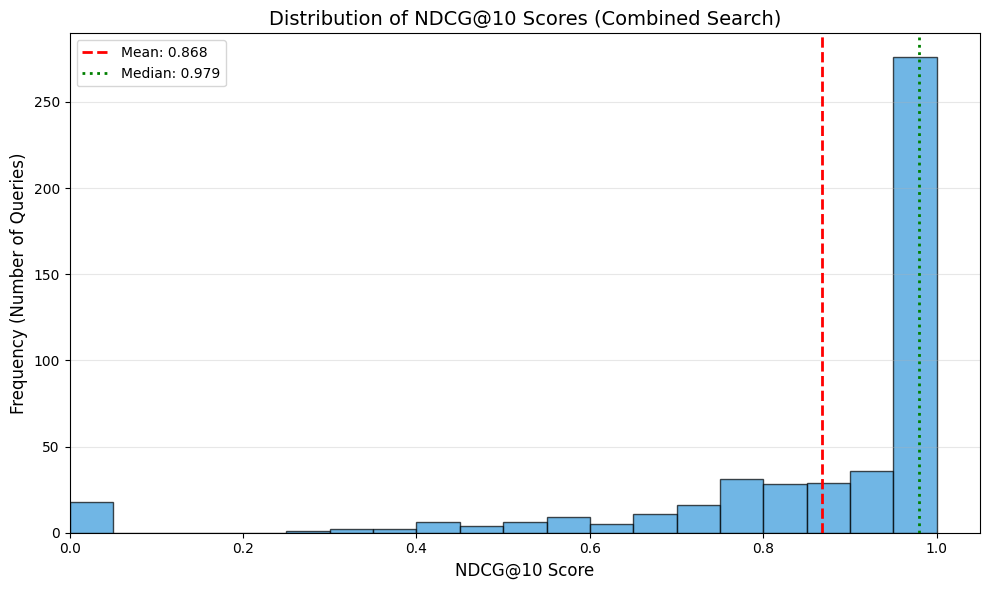

Total Queries Evaluated: 480
Mean NDCG: 0.8682
Median NDCG: 0.9792
Queries with 0.0 score: 18


In [35]:
import matplotlib.pyplot as plt

# Create the visualization
plt.figure(figsize=(10, 6))

plt.hist(evaluation_results['ndcg'], bins=20, color='#3498db', edgecolor='black', alpha=0.7)

mean_ndcg = evaluation_results['ndcg'].mean()
median_ndcg = evaluation_results['ndcg'].median()

plt.axvline(mean_ndcg, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_ndcg:.3f}')
plt.axvline(median_ndcg, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_ndcg:.3f}')

plt.title('Distribution of NDCG@10 Scores (Combined Search)', fontsize=14)
plt.xlabel('NDCG@10 Score', fontsize=12)
plt.ylabel('Frequency (Number of Queries)', fontsize=12)
plt.xlim(0, 1.05)  # Slight padding for the 1.0 bar
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary stats for quick reference
print(f"Total Queries Evaluated: {len(evaluation_results)}")
print(f"Mean NDCG: {mean_ndcg:.4f}")
print(f"Median NDCG: {median_ndcg:.4f}")
print(f"Queries with 0.0 score: {(evaluation_results['ndcg'] == 0).sum()}")

#code provided from gemini

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [36]:
# Task 6a: Index product_class field

# YOUR CODE HERE


In [37]:
# 1. Prepare the product_class list
product_classes = df_products['product_class'].tolist()

# 2. Build the index and doc lengths for product_class
product_class_index, product_class_doc_lengths = build_index(product_classes, snowball_tokenize)

print(f"Index built for product_class with {len(product_class_index):,} terms.")

Index built for product_class with 628 terms.


In [38]:
def combined_search_3_fields(query: str, k: int = 10) -> pd.DataFrame:
   
    num_docs = len(df_products)
    
    # Score Name
    name_scores = score_bm25(
        query, product_name_index, num_docs, 
        product_name_doc_lengths, snowball_tokenize
    )
    
    # Score Description
    desc_scores = score_bm25(
        query, product_description_index, num_docs, 
        product_description_doc_lengths, snowball_tokenize
    )
    
    # Score Class
    class_scores = score_bm25(
        query, product_class_index, num_docs, 
        product_class_doc_lengths, snowball_tokenize
    )

    # Combine all three scores
    combined_scores = name_scores + desc_scores + class_scores
    
    # Get top-k results
    top_k_idx = np.argsort(-combined_scores)[:k]
    
    results = df_products.iloc[top_k_idx].copy()
    results['score'] = combined_scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results

# Test the new search
results = combined_search_3_fields("modern leather sofa")
display(results[['rank', 'score', 'product_name', 'product_class']])

,rank,score,product_name,product_class
18735,1,22.618067,hardee 86 '' genuine leather tuxedo arm sofa,Reception Sofas & Loveseats|Sofas
29667,2,21.049362,canyon 136 '' genuine leather pillow top arm sofa,Sofas
30152,3,20.294316,krehbiel 72 '' faux leather flared arm sofa,Reception Sofas & Loveseats|Sofas
29494,4,20.277099,obryant 88.5 '' faux leather square arm sofa,Sofas
37472,5,19.928628,nataly 79.2 '' faux leather pillow top arm sofa,Reception Sofas & Loveseats|Sofas
41272,6,19.865875,sabbattus 74 '' faux leather charles of london...,Reception Sofas & Loveseats|Sofas
36125,7,19.653145,hailee 84 '' genuine leather square arm sofa,Sofas
38685,8,19.411899,chafin contemporary leather sofa,Reception Sofas & Loveseats|Sofas
23531,9,19.329645,pennock 71 '' faux leather armless sleeper,Sofas
19078,10,18.990506,micheals 95 '' genuine leather square arm sofa,Sofas


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [39]:
# Task 6b: Evaluate three-field search

# YOUR CODE HERE


In [40]:
# Run the evaluation across all queries in your dataset
evaluation_results_3_fields_search = evaluate_search(
    search_func=combined_search_3_fields,
    products_df=df_products,
    queries_df=df_queries,
    labels_df=df_labels,
    k=10
)

# Display the queries where your search performed the best
print("\nTop 5 Best Performing Queries:")
display(evaluation_results_3_fields_search.sort_values('ndcg', ascending=False).head(5))

Evaluated 480 queries
Mean NDCG@10: 0.8792

Top 5 Best Performing Queries:


,query_id,query,ndcg
0,0,salon chair,1.0
246,250,multi color rug,1.0
260,264,cortez pillow,1.0
256,260,retractable side awning,1.0
252,256,high weight capacity bunk beds,1.0


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [41]:
# Task 6c: Compare to baseline

# YOUR CODE HERE

In [42]:
# Run Evaluation for both methods
print("Evaluating Baseline (Name + Desc)...")
df_eval_baseline = evaluate_search(combined_search, df_products, df_queries, df_labels, k=10)

print("\nEvaluating Three-Field (Name + Desc + Class)...")
df_eval_three_field = evaluate_search(combined_search_3_fields, df_products, df_queries, df_labels, k=10)

# Merge results to compare
comparison_df = df_eval_baseline.rename(columns={'ndcg': 'ndcg_baseline'}).merge(
    df_eval_three_field[['query_id', 'ndcg']].rename(columns={'ndcg': 'ndcg_3field'}),
    on='query_id'
)

# Calculate the "Delta" (improvement or degradation)
comparison_df['delta'] = comparison_df['ndcg_3field'] - comparison_df['ndcg_baseline']

# Show Top 5 Improved and Top 5 Degraded
print("\n" + "="*50)
print("TOP 5 IMPROVED QUERIES")
print("="*50)
display(comparison_df.sort_values('delta', ascending=False).head(5))

print("\n" + "="*50)
print("TOP 5 DEGRADED QUERIES")
print("="*50)
display(comparison_df.sort_values('delta', ascending=True).head(5))

Evaluating Baseline (Name + Desc)...
Evaluated 480 queries
Mean NDCG@10: 0.8682

Evaluating Three-Field (Name + Desc + Class)...
Evaluated 480 queries
Mean NDCG@10: 0.8792

TOP 5 IMPROVED QUERIES


,query_id,query,ndcg_baseline,ndcg_3field,delta
339,344,ottoman bed queen,0.000000,0.693426,0.693426
447,454,carpet 5x6,0.386853,0.955024,0.568171
240,244,pull out sleeper loveseat,0.000000,0.505128,0.505128
403,409,teal chair,0.000000,0.471628,0.471628
84,84,full metal bed rose gold,0.554827,0.996349,0.441522



TOP 5 DEGRADED QUERIES


,query_id,query,ndcg_baseline,ndcg_3field,delta
304,309,moen 5995 arbor one,0.921787,0.289065,-0.632722
45,45,70s inspired furniture,0.583342,0.000000,-0.583342
42,42,toddler couch fold out,0.919721,0.468451,-0.451270
13,13,outdoor privacy wall,0.927414,0.500000,-0.427414
134,134,black hanging bookshelf,1.000000,0.630930,-0.369070


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [43]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevcant from the query

# Define Pydantic model for structured output
class QueryInfo(BaseModel):
    """Structured information extracted from a search query."""
    product_type: Optional[str] = Field(
        None, 
        description="The main type of product the user is looking for (e.g., 'rug', 'coffee table', 'sofa', 'bookshelf')"
    )
    theme: Optional[str] = Field(
        None,
        description="The theme, style, or brand mentioned in the query (e.g., 'star wars', 'modern', 'vintage')"
    )
    material: Optional[str] = Field(
        None,
        description="The material mentioned in the query (e.g., 'wood', 'leather', 'metal', 'glass')"
    )
    color: Optional[str] = Field(
        None,
        description="The color mentioned in the query (e.g., 'blue', 'red', 'black', 'white')"
    )
    style: Optional[str] = Field(
        None,
        description="The style or design aesthetic mentioned (e.g., 'modern', 'traditional', 'rustic', 'minimalist')"
    )
    size: Optional[str] = Field(
        None,
        description="Size or dimension information if mentioned (e.g., 'large', 'small', 'queen', 'twin')"
    )
    other_keywords: Optional[list[str]] = Field(
        default_factory=list,
        description="Any other relevant keywords or attributes mentioned in the query"
    )

def extract_query_info(query: str) -> QueryInfo:
    """
    Extract structured information from a search query using an LLM.
    
    Args:
        query: The search query text
        
    Returns:
        QueryInfo object with extracted information
    """
    # Create a prompt that includes the schema
    schema_prompt = """Extract structured information from the search query. Return a JSON object with these fields:
- product_type: The main type of product (e.g., 'rug', 'coffee table', 'sofa')
- theme: Theme, style, or brand (e.g., 'star wars', 'cats','vintage')
- material: Material mentioned (e.g., 'wood', 'leather', 'metal', 'glass')
- color: Color mentioned (e.g., 'blue', 'red', 'black')
- style: Design aesthetic (e.g., 'modern', 'traditional', 'rustic')
- size: Size or dimensions if mentioned (e.g., 'large', 'small', 'queen')
- other_keywords: List of any other relevant keywords

If a field is not mentioned in the query, set it to null. Return only valid JSON."""
    
    response = litellm.completion(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant that extracts structured product information from e-commerce search queries. Always return valid JSON."
            },
            {
                "role": "user",
                "content": f"{schema_prompt}\n\nQuery: '{query}'"
            }
        ],
        response_format={"type": "json_object"},
        max_tokens=200
    )
    
    # Parse the JSON response
    import json
    response_content = response.choices[0].message.content
    parsed_data = json.loads(response_content)
    
    # Convert to QueryInfo object (handle missing fields gracefully)
    return QueryInfo(**parsed_data)


# code provided by cursor

In [44]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    print(f"\n{'='*60}")
    print(f"Query: '{q}'")
    print('='*60)
    query_info = extract_query_info(q)
    print(f"Product Type: {query_info.product_type}")
    print(f"Theme: {query_info.theme}")
    print(f"Material: {query_info.material}")
    print(f"Color: {query_info.color}")
    print(f"Style: {query_info.style}")
    print(f"Size: {query_info.size}")
    print(f"Other Keywords: {query_info.other_keywords}")


Query: 'star wars rug'
Product Type: rug
Theme: star wars
Material: None
Color: None
Style: None
Size: None
Other Keywords: []

Query: 'wooden coffee table'
Product Type: coffee table
Theme: None
Material: wood
Color: None
Style: None
Size: None
Other Keywords: []

Query: 'blue leather sofa'
Product Type: sofa
Theme: None
Material: leather
Color: blue
Style: None
Size: None
Other Keywords: []

Query: 'modern metal bookshelf'
Product Type: bookshelf
Theme: None
Material: metal
Color: None
Style: modern
Size: None
Other Keywords: []


### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [45]:
# Task 7b: Create an LLM-enhanced search

def llm_enhanced_search(query: str, k: int = 10, boost_weight: float = 2.0) -> pd.DataFrame:
    """
    LLM-enhanced search that uses extracted query information to boost matching products.
    
    Args:
        query: The search query text
        k: Number of results to return
        boost_weight: Multiplier for boosting matching products (default 2.0)
        
    Returns:
        DataFrame with top-k products and enhanced scores
    """
    num_docs = len(df_products)
    
    # BM25 scores from all three fields
    name_scores = score_bm25(
        query, product_name_index, num_docs, 
        product_name_doc_lengths, snowball_tokenize
    )
    
    desc_scores = score_bm25(
        query, product_description_index, num_docs, 
        product_description_doc_lengths, snowball_tokenize
    )
    
    class_scores = score_bm25(
        query, product_class_index, num_docs, 
        product_class_doc_lengths, snowball_tokenize
    )
    
    # Combine BM25 scores
    combined_scores = name_scores + desc_scores + class_scores
    
    # Extract structured information from query using LLM
    query_info = extract_query_info(query)
    
    # Create boost array (initialize with zeros)
    boost_scores = np.zeros(num_docs)
    
    # Boost products that match extracted product_type in product_class
    if query_info.product_type:
        # Tokenize the product_type for matching
        product_type_tokens = snowball_tokenize(query_info.product_type)
        
        # Check each product's class for matches
        for idx, product_class in enumerate(df_products['product_class']):
            if pd.isna(product_class):
                continue
                
            class_tokens = snowball_tokenize(str(product_class).lower())
            
            # If any product_type token matches in the class, add boost
            if any(token in class_tokens for token in product_type_tokens):
                boost_scores[idx] += boost_weight
    
    
    # Combine BM25 scores with LLM-based boosts
    enhanced_scores = combined_scores + boost_scores
    
    # Get top-k results
    top_k_idx = np.argsort(-enhanced_scores)[:k]
    
    results = df_products.iloc[top_k_idx].copy()
    results['score'] = enhanced_scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    
    return results


In [46]:
# Test the LLM-enhanced search
test_query = "modern metal bookshelf"

print(f"Testing LLM-enhanced search for: '{test_query}'")
print("="*60)

# Get query info to see what was extracted
query_info = extract_query_info(test_query)
print(f"\nExtracted Information:")
print(f"  Product Type: {query_info.product_type}")
print(f"  Theme: {query_info.theme}")
print(f"  Material: {query_info.material}")
print(f"  Color: {query_info.color}")

# Run the enhanced search
results = llm_enhanced_search(test_query, k=10)

print(f"\nTop 10 Results:")
display(results[['rank', 'score', 'product_name', 'product_class']])

# Compare with baseline 3-field search
print(f"\nComparison with baseline 3-field search:")
baseline_results = combined_search_3_fields(test_query, k=10)
print(f"\nBaseline Top 3:")
display(baseline_results[['rank', 'score', 'product_name', 'product_class']].head(3))
print(f"\nLLM-Enhanced Top 3:")
display(results[['rank', 'score', 'product_name', 'product_class']].head(3))

Testing LLM-enhanced search for: 'modern metal bookshelf'

Extracted Information:
  Product Type: bookshelf
  Theme: None
  Material: metal
  Color: None

Top 10 Results:


,rank,score,product_name,product_class
4301,1,20.052673,bookshelf,Bookcases
28253,2,17.569410,miyamoto bookshelf standard bookcase,Bookcases
6686,3,14.766984,computer desk 47 '' spacious computer table wi...,Desks
17884,4,14.141786,ranallo 3-tier rustic industrial wood and meta...,Bookcases
14393,5,13.570353,cait bookshelf,Bookcases
759,6,13.365375,pinegar metal 4 door accent cabinet,Accent Chests / Cabinets
42441,7,13.082625,haland metal bookcase,Bookcases
29024,8,12.877363,onley computer desk with bookshelf 47-inch hom...,Desks
40167,9,12.704980,dartington new huge butterfly vine and vintage...,Wall Stickers
1270,10,12.058679,forshee 75 '' h x 49 '' w metal geometric book...,Bookcases



Comparison with baseline 3-field search:

Baseline Top 3:


,rank,score,product_name,product_class
4301,1,20.052673,bookshelf,Bookcases
28253,2,17.569410,miyamoto bookshelf standard bookcase,Bookcases
6686,3,14.766984,computer desk 47 '' spacious computer table wi...,Desks



LLM-Enhanced Top 3:


,rank,score,product_name,product_class
4301,1,20.052673,bookshelf,Bookcases
28253,2,17.569410,miyamoto bookshelf standard bookcase,Bookcases
6686,3,14.766984,computer desk 47 '' spacious computer table wi...,Desks


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
